Guardare Mixture Density Netwotk

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
POISS_SUPP = 50
torch.set_default_dtype(torch.float64)

In [4]:
class PoissonNetwork(nn.Module):
    def __init__(self, input_size=POISS_SUPP, num_component_output=2): 
        super(PoissonNetwork, self).__init__()
        self.input_size = input_size
        self.num_component_output = num_component_output
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,3*num_component_output)             # modified output to get 1 component only
        )

    def forward(self, x):
        output = self.network(x)
        pi = output[:, 0:self.num_component_output]
        mu = output[:, self.num_component_output:2*self.num_component_output]
        sigma = output[:, 2*self.num_component_output:3*self.num_component_output]

        pi = torch.softmax(pi, dim=1)
        sigma = torch.exp(sigma) #torch.relu(sigma)            # try relu
        mu = torch.exp(mu) #torch.relu(mu)           # try relu

        return pi, mu, sigma

In [5]:
def loss_function_minibatch_poisson(y_poisson, new_pi, new_mu, new_sigma):
    count = 0
    total_loss = 0
    for poisson_sample in y_poisson:
        #Generate the new gaussian mixture
        mix_new = torch.distributions.Categorical(new_pi[count])
        comp_new = torch.distributions.Normal(new_mu[count], new_sigma[count])
        gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

        # Calculate the log likelihood of the new gaussian mixture with the old samples
        log_likelihood = torch.sum(gmm_new.log_prob(poisson_sample))
        #mean_diff = torch.abs(new_mu[count] - torch.mean(poisson_sample.float()))[0]
        total_loss -= 0.1*log_likelihood          # rescaled log_likelihood to make it comparable to mean_diff
        #total_loss += mean_diff                  # added regularization factor to ensure the sample mean and the estimated one are similar
        count += 1
    return total_loss/count


In [6]:
def train_loop_minibatch_poisson(training_dataloader, model, loss_fn, optimizer, n_samples=250):
    model.train()
    counter = 0
    
    for bach_idx, poisson_densities in enumerate(training_dataloader):
        y_poisson = []

        for density in poisson_densities:
            y_poisson.append(torch.distributions.Categorical(probs=density).sample((n_samples,)))
        pi_new, mu_new, sigma_new = model(poisson_densities)
            
        loss = loss_fn(y_poisson, pi_new, mu_new, sigma_new)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if counter % 100 == 0:
            loss = loss.item() #batch * batch_size + len(X)
            print(f"loss: {loss:>7f}")
        counter += 1


In [7]:
import torch.nn.functional as F
from torch.distributions.normal import Normal

def generate_poisson(pi, mu, sigma, end = POISS_SUPP):
    """
    Input:
    pi = tensor of weights of length c
    mu = tensor of means of length c
    sigma = tensor of variances of length c
    Taken as input the parameters of a Gaussian Mixtures returns the
    density of a Poisson distribution having as rate given mixture, truncated to [0, end]
    """
    c = len(pi)   # number of components in the mixture
    
    # initializes the density vector, storing a density for each component
    pois_dens = torch.zeros((c, end))
    # initializes the vector of factorials
    log_fact = torch.tensor([sum([torch.log(torch.tensor(float(i))) for i in range(1, n)]) for n in range(1, end+1)])
    
    # computes the Gaussian density for each component
    muprime = mu - sigma
    std = torch.sqrt(sigma)
    norm = Normal(torch.tensor(0.0), torch.tensor(1.0))

    for i in range(c):
        for k_val in range(end):
            if k_val == 0:
                pois_dens[i, k_val] = 1 - norm.cdf(-muprime[i]/std[i])
            elif k_val == 1:
                pois_dens[i, k_val] = muprime[i] * pois_dens[i, k_val-1] + std[i] * norm.log_prob(-muprime[i]/std[i]).exp()
            else:
                pois_dens[i, k_val] = (muprime[i] * pois_dens[i, k_val-1] + (k_val-1) * sigma[i] * pois_dens[i, k_val-2])
        # goes to logarithm to compute the factorial
        pois_dens[i, :] = torch.log(pois_dens[i, :]) - log_fact
        pois_dens[i, :] = pois_dens[i, :].exp()
        # multiplies by normalization constant
        pois_dens[i, :] = pois_dens[i, :] * torch.exp(0.5 * (sigma[i] - 2 * mu[i]))
        # puts missing probability mass to zero
        pois_dens[i, 0] += 1 - pois_dens[i, :].sum()

    # compute product between weights and densities per component
    pois_dens = pi.reshape(1, c).matmul(pois_dens).reshape(end, )
    return pois_dens


# Fitting with 1 component

In [8]:
# Define the number of samples in the dataset
num_samples = 10000

from scipy.stats import qmc

l_bounds = [0, 0.01] # lower bounds on mu and sigma
u_bounds = [10, 6]   # upper bounds on mu and sigma

sampler = qmc.LatinHypercube(d=2)   # d=5                           # changed the way it samples (is it correct?)
samples = sampler.random(n=num_samples)

samples = qmc.scale(samples, [0, 0.01], [10, 6])
dataset = torch.hstack([torch.ones(num_samples).reshape(num_samples,1), torch.tensor(samples)])
dataset

tensor([[1.0000, 3.3072, 3.6852],
        [1.0000, 5.5911, 5.7030],
        [1.0000, 1.6603, 5.9991],
        ...,
        [1.0000, 2.1178, 3.3771],
        [1.0000, 3.6530, 2.5846],
        [1.0000, 5.4402, 3.6785]])

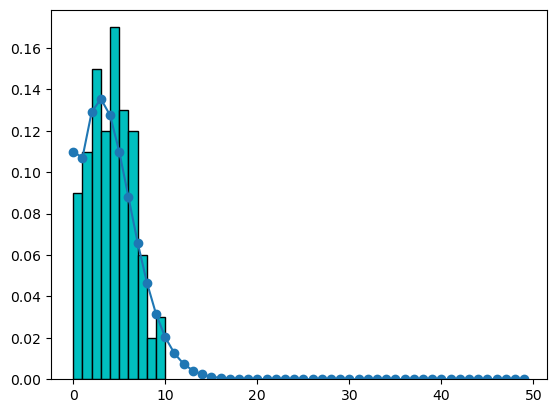

In [9]:
#Check how it works

pi = torch.tensor([1.])
mu = torch.tensor([4.])
sigma = torch.tensor([5.])

pois_dens = generate_poisson(pi, mu, sigma)
pois_dens

#sample 100 points from a categorical distribution with the weights pois_dens
sample = torch.distributions.Categorical(probs=pois_dens).sample((100,))

plt.hist(sample, bins=10, density=True, color='c', edgecolor='black')
plt.plot(range(50), pois_dens, marker= 'o')


In [10]:
training_data = dataset[:int(0.85*len(dataset))]

#build a tensor that replaces each of the rows of the training_data with the corresponding generate_poisson
def generate_poisson_dataset_dim1(training_data):
    #y_poisson = []
    poisson_densities = []
    for gaussian_mix_old in training_data:
        old_pi = torch.tensor([gaussian_mix_old[0]])
        old_mu = torch.tensor([gaussian_mix_old[1]])
        old_sigma = torch.tensor([gaussian_mix_old[2]])
        pois_dens = generate_poisson(old_pi, old_mu, old_sigma)
        #y_poisson.append(torch.distributions.Categorical(probs=torch.tensor(pois_dens)).sample((250,)))
        poisson_densities.append(pois_dens)
    return torch.stack(poisson_densities) #,torch.stack(y_poisson)

densities = generate_poisson_dataset_dim1(training_data)    # densities contiene le densità, y_poisson i samples

In [11]:
epochs = 100
model = PoissonNetwork(input_size=POISS_SUPP, num_component_output=1)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_dataloader = DataLoader(densities, batch_size=64)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_minibatch_poisson(train_dataloader, model, loss_function_minibatch_poisson, optimizer)
    #test_loop(test_data, model, loss_function)
print("Done!")
torch.save(model, 'params/poisson_dim1.pth')

Epoch 1
-------------------------------
loss: 357.916171
loss: 69.814694
Epoch 2
-------------------------------
loss: 68.203505
loss: 66.946767
Epoch 3
-------------------------------
loss: 64.383918
loss: 60.945466
Epoch 4
-------------------------------
loss: 59.272301
loss: 60.477455
Epoch 5
-------------------------------
loss: 58.836017
loss: 60.367218
Epoch 6
-------------------------------
loss: 59.162940
loss: 60.293654
Epoch 7
-------------------------------
loss: 58.833234
loss: 60.385314
Epoch 8
-------------------------------
loss: 59.042561
loss: 60.726774
Epoch 9
-------------------------------
loss: 58.776693
loss: 60.331841
Epoch 10
-------------------------------
loss: 58.709254
loss: 60.721770
Epoch 11
-------------------------------
loss: 58.817587
loss: 60.520365
Epoch 12
-------------------------------
loss: 58.822838
loss: 60.573352
Epoch 13
-------------------------------
loss: 59.041602
loss: 60.428819
Epoch 14
-------------------------------
loss: 58.564097
lo

### Test

In [12]:
import torch
from torch import nn
#from neural_soga import *

import matplotlib.pyplot as plt
import numpy as np

Neural network: [[8.00287689]] [[1.819605]]
SOGA values: 8.000000001822134 3.1622776557139574


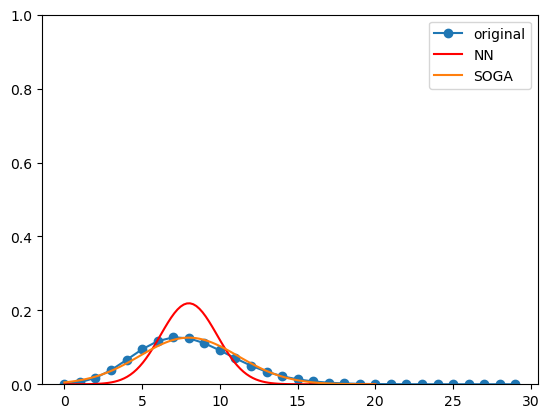

In [13]:
from scipy.stats import norm

model = PoissonNetwork(input_size=50, num_component_output=1)
model = torch.load('params/poisson_dim1.pth')

#Check with some distributions
# 1.0000, 5.4371, 0.0294
pi = torch.tensor([1.])
mu = torch.tensor([8.0])
sigma = torch.tensor([2])

pois_dens = generate_poisson(pi, mu, sigma)
plt.plot(range(30), pois_dens[0:30], marker= 'o', label='original')

pi_new, mu_new, sigma_new = model(pois_dens.reshape(1,50).double())
print('Neural network:', mu_new.detach().numpy(), torch.sqrt(sigma_new).detach().numpy())
mix_new = torch.distributions.Categorical(pi_new)
comp_new = torch.distributions.Normal(mu_new, torch.sqrt(sigma_new))
gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

x = np.linspace(0,20,100)

plt.plot(x, gmm_new.log_prob(torch.tensor(x).reshape(100,1)).exp().detach().numpy(), color='r', label='NN')

pois_dens = pois_dens.detach().numpy()
pois_mean = sum([i*pois_dens[i] for i in range(len(pois_dens))])
pois_std = np.sqrt(sum([i**2*pois_dens[i] for i in range(len(pois_dens))]) - pois_mean**2)
print('SOGA values:', pois_mean, pois_std)
plt.plot(x, norm.pdf(x, loc=pois_mean, scale=pois_std), label='SOGA')
plt.ylim(0, 1)

plt.legend()

plt.savefig('poisson_fit_1comp_NN.png')

For some reason it does not guess the mean accurately

# Da qui in poi non eseguire

# Fitting with 2 components

In [14]:
# Define the number of samples in the dataset
num_samples = 10000

from scipy.stats import qmc


l_bounds = [0, 0, 0, 0.01, 0.01] # lower bounds on p1, mu1, mu2, sigma1 and sigma2
u_bounds = [1, 10, 10, 2, 2]   # upper bounds on p1, mu1, mu2, sigma1 and sigma2

sampler = qmc.LatinHypercube(d=5)   # d=5
samples = sampler.random(n=num_samples)

samples = qmc.scale(samples,l_bounds, u_bounds)
dataset = torch.hstack([torch.tensor(1-samples[:,0].reshape(num_samples,1)), torch.tensor(samples)])
dataset


tensor([[0.7045, 0.2955, 5.8413, 6.9997, 1.0881, 0.7212],
        [0.1256, 0.8744, 8.6940, 9.5081, 1.1982, 0.4788],
        [0.9401, 0.0599, 7.5359, 1.4697, 0.9770, 1.7505],
        ...,
        [0.3647, 0.6353, 0.0312, 7.5845, 0.5019, 0.2001],
        [0.0621, 0.9379, 4.1791, 6.2192, 0.9778, 1.1768],
        [0.8994, 0.1006, 9.9678, 2.5038, 1.3766, 0.1746]])

In [15]:
import torch.nn.functional as F
from torch.distributions.normal import Normal

def generate_poisson(pi, mu, sigma, end = POISS_SUPP):
    """
    Input:
    pi = tensor of weights of length c
    mu = tensor of means of length c
    sigma = tensor of variances of length c
    Taken as input the parameters of a Gaussian Mixtures returns the
    density of a Poisson distribution having as rate given mixture, truncated to [0, end]
    """
    c = len(pi)   # number of components in the mixture
    
    # initializes the density vector, storing a density for each component
    pois_dens = torch.zeros((c, end))
    # initializes the vector of factorials
    log_fact = torch.tensor([sum([torch.log(torch.tensor(float(i))) for i in range(1, n)]) for n in range(1, end+1)])
    
    # computes the Gaussian density for each component
    muprime = mu - sigma
    std = torch.sqrt(sigma)
    norm = Normal(torch.tensor(0.0), torch.tensor(1.0))

    for i in range(c):
        for k_val in range(end):
            if k_val == 0:
                pois_dens[i, k_val] = 1 - norm.cdf(-muprime[i]/std[i])
            elif k_val == 1:
                pois_dens[i, k_val] = muprime[i] * pois_dens[i, k_val-1] + std[i] * norm.log_prob(-muprime[i]/std[i]).exp()
            else:
                pois_dens[i, k_val] = (muprime[i] * pois_dens[i, k_val-1] + (k_val-1) * sigma[i] * pois_dens[i, k_val-2])
        # goes to logarithm to compute the factorial
        pois_dens[i, :] = torch.log(pois_dens[i, :]) - log_fact
        pois_dens[i, :] = pois_dens[i, :].exp()
        # multiplies by normalization constant
        pois_dens[i, :] = pois_dens[i, :] * torch.exp(0.5 * (sigma[i] - 2 * mu[i]))
        # puts missing probability mass to zero
        pois_dens[i, 0] += 1 - pois_dens[i, :].sum()

    # compute product between weights and densities per component
    pois_dens = pi.reshape(1, c).matmul(pois_dens).reshape(end, )
    return pois_dens


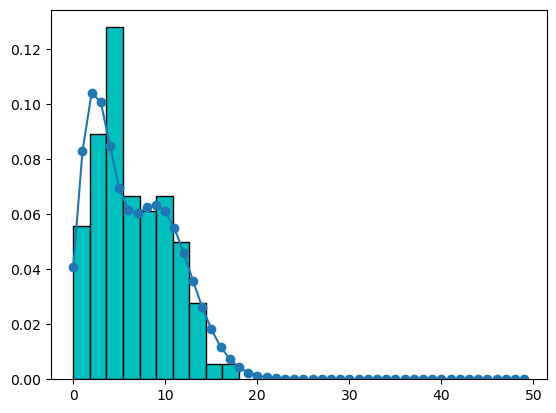

In [16]:
#Check how it works

pi = torch.tensor([0.5, 0.5])
mu = torch.tensor([3, 10])
sigma = torch.tensor([1, 1])

pois_dens = generate_poisson(pi, mu, sigma)
pois_dens

#sample 100 points from a categorical distribution with the weights pois_dens
sample = torch.distributions.Categorical(probs=pois_dens).sample((100,))

plt.hist(sample, bins=10, density=True, color='c', edgecolor='black')
plt.plot(range(50), pois_dens, marker= 'o')


In [17]:
def loss_function_minibatch_poisson(y_poisson, new_pi, new_mu, new_sigma):
    count = 0
    total_loss = 0
    for poisson_sample in y_poisson:
        #Generate the new gaussian mixture
        mix_new = torch.distributions.Categorical(new_pi[count])
        comp_new = torch.distributions.Normal(new_mu[count], new_sigma[count])
        gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

    
        # Calculate the log likelihood of the new gaussian mixture with the old samples
        log_likelihood = torch.sum(gmm_new.log_prob(poisson_sample))
        total_loss -= log_likelihood/len(poisson_sample)
        count += 1
    return total_loss/count


In [18]:
def train_loop_minibatch_poisson(training_dataloader, model, loss_fn, optimizer, n_samples=250):
    model.train()
    counter = 0
    
    for bach_idx, poisson_denisties in enumerate(training_dataloader):
        y_poisson = []

        for density in poisson_denisties:
            y_poisson.append(torch.distributions.Categorical(probs=density).sample((n_samples,)))
        pi_new, mu_new, sigma_new = model(poisson_denisties)
            
        loss = loss_fn(y_poisson, pi_new, mu_new, sigma_new)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if counter % 100 == 0:
            loss = loss.item() #batch * batch_size + len(X)
            print(f"loss: {loss:>7f}")
        counter += 1



In [19]:
training_data = dataset[:int(0.85*len(dataset))]

#build a tensor that replaces each of the rows of the training_data with the corresponding generate_poisson
def generate_poisson_dataset(training_data):
    y_poisson = []
    poisson_denisties = []
    for gaussian_mix_old in training_data:
        old_pi = gaussian_mix_old[0:2]
        old_mu = gaussian_mix_old[2:4]
        old_sigma = gaussian_mix_old[4:6]
        pois_dens = generate_poisson(old_pi, old_mu, old_sigma)
        #y_poisson.append(torch.distributions.Categorical(probs=torch.tensor(pois_dens)).sample((250,)))
        poisson_denisties.append(pois_dens)
    return torch.stack(poisson_denisties)#,torch.stack(y_poisson)


densities = generate_poisson_dataset(training_data)    # densities contiene le densità, y_poisson i samples

In [20]:
densities

tensor([[3.9125e-03, 1.9187e-02, 4.9509e-02,  ..., 1.2736e-20, 2.6044e-21,
         5.2487e-22],
        [1.2079e-04, 1.0319e-03, 4.4813e-03,  ..., 5.9102e-17, 1.3949e-17,
         3.2431e-18],
        [2.2542e-02, 1.8554e-02, 2.8162e-02,  ..., 1.0015e-18, 2.2588e-19,
         5.0204e-20],
        ...,
        [6.7900e-02, 2.2490e-02, 2.0504e-02,  ..., 1.1096e-19, 2.2011e-20,
         4.2923e-21],
        [7.6380e-03, 3.0745e-02, 6.9014e-02,  ..., 2.0927e-20, 4.6035e-21,
         9.9978e-22],
        [1.3389e-01, 2.3912e-01, 2.3328e-01,  ..., 7.6479e-19, 1.6645e-19,
         3.5582e-20]])

In [21]:
epochs = 100
model = PoissonNetwork(input_size=POISS_SUPP, num_component_output=2)

optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
train_dataloader = DataLoader(densities, batch_size=64)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_minibatch_poisson(train_dataloader, model, loss_function_minibatch_poisson, optimizer, n_samples=500)
    #test_loop(test_data, model, loss_function)
print("Done!")
torch.save(model, 'model4.pth')

Epoch 1
-------------------------------
loss: 15.129186
loss: 13.599661
Epoch 2
-------------------------------
loss: 13.790430
loss: 12.407295
Epoch 3
-------------------------------
loss: 12.750248
loss: 11.548511
Epoch 4
-------------------------------
loss: 11.624602
loss: 10.781763
Epoch 5
-------------------------------
loss: 10.940168
loss: 10.009715
Epoch 6
-------------------------------
loss: 10.216532
loss: 9.476261
Epoch 7
-------------------------------
loss: 9.648925
loss: 8.957547
Epoch 8
-------------------------------
loss: 9.168607
loss: 8.481687
Epoch 9
-------------------------------
loss: 8.827688
loss: 8.169109
Epoch 10
-------------------------------
loss: 8.326859
loss: 7.741053
Epoch 11
-------------------------------
loss: 7.953469
loss: 7.483665
Epoch 12
-------------------------------
loss: 7.638525
loss: 7.173689
Epoch 13
-------------------------------
loss: 7.401014
loss: 6.904713
Epoch 14
-------------------------------
loss: 7.056919
loss: 6.728330
Epoc

KeyboardInterrupt: 

tensor([[0.5822, 0.4178]], grad_fn=<SoftmaxBackward0>) tensor([[1.1721, 0.9504]], grad_fn=<ExpBackward0>) tensor([[3.7374, 1.0035]], grad_fn=<ExpBackward0>)


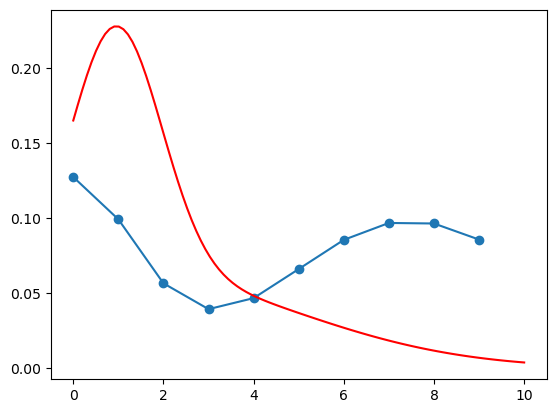

In [22]:
#Check with some distributions
pi = torch.tensor([0.3, 0.7])
mu = torch.tensor([0.95, 8])
sigma = torch.tensor([0.2, 0.2])

pois_dens = generate_poisson(pi, mu, sigma)
plt.plot(range(10), pois_dens[0:10], marker= 'o')

pi_new, mu_new, sigma_new = model(pois_dens.reshape(1,50))
mix_new = torch.distributions.Categorical(pi_new)
comp_new = torch.distributions.Normal(mu_new, sigma_new)
gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)
print(pi_new, mu_new, sigma_new)
plt.plot(np.linspace(0, 10, 100), gmm_new.log_prob(torch.tensor(np.linspace(0, 10, 100)).reshape(100,1)).exp().detach().numpy(), color='r')
#plt.ylim(0, 1)



In [63]:
model(pois_dens.reshape(1,50))

(tensor([[0.5685, 0.4315]], grad_fn=<SoftmaxBackward0>),
 tensor([[1.1636, 1.0067]], grad_fn=<ExpBackward0>),
 tensor([[4.0661, 0.9995]], grad_fn=<ExpBackward0>))